## Parameter tuning with `PredictTutor` class.

This class assumes the next point or set of points to check.
- Multi and single objective
- Models portfolio
- If there is no correct model takes a point from the sampling plan.
- Random or Sobol sequence sampling plan.

> "For 800 years have I trained Jedi." ―Yoda, to Luke Skywalker

In [46]:
import sys
sys.path.append('..')

# --- Dependencies
import pygmo as pg
import numpy as np
import pandas as pd
# import dovpanda

import plotly
from plotly import graph_objs as go
from plotly import tools
import plotly.express as px

import sklearn.gaussian_process as gp
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from src.composite import PredictTutor, ModelsUnion
from src.generator import SamplesGenerator
from src.ploting import plot_mo

from src.hypothesis.tpot_estimator import TpotWrp
from src.hypothesis.custom_gp_kernel import KERNEL_MAUNA, KERNEL_SIMPLE, KERNEL_GPML

### Problem definition

In [50]:
DIM = 2
ID = 4
OBJ = 2

# --- Problem
udp = pg.wfg(prob_id=ID, dim_dvs=DIM, dim_obj=OBJ, dim_k=OBJ-1)
# udp = pg.zdt(prob_id=ID, param=DIM)
pro = pg.problem(udp)

### Initialization a models for portfolio

In [3]:
# 1
tea_pot = TpotWrp(generations=2, population_size=10, random_state=42) 
# 2
gp_sim = gp.GaussianProcessRegressor(kernel=KERNEL_SIMPLE, alpha=0, n_restarts_optimizer=10, normalize_y=True) 
# 3
grad_uni = ModelsUnion(
    models=[GradientBoostingRegressor(n_estimators=200)],
    split_y=True) 
# 4 
lin_uni = ModelsUnion(models=[LinearRegression()], split_y=True)

### Prediction tutor

In [4]:
gen = SamplesGenerator(pro)
tutor = Pred  ictTutor(pro.get_bounds(), portfolio=[tea_pot, gp_sim, grad_uni, lin_uni])

iter_solution = []
x=0
while x < 30:
    x=x+1
    print("\n--- {}".format(x))
    X, y = gen.return_X_y()
    iter_solution.append(tutor.solution)
    propos = tutor.next_config(X, y, n=1+x, cv=4)
    gen.update(propos.tolist(), [pro.fitness(p).tolist() for p in propos])


--- 1
Initialization data generator

--- 2
In dataset add 3 new results

--- 3
In dataset add 4 new results

--- 4
Split dataset. Validation is 0.25%
In dataset add 5 new results

--- 5
Split dataset. Validation is 0.25%
In dataset add 6 new results

--- 6
Split dataset. Validation is 0.25%
In dataset add 7 new results

--- 7
Split dataset. Validation is 0.25%
In dataset add 8 new results

--- 8
Split dataset. Validation is 0.25%
In dataset add 9 new results

--- 9
Split dataset. Validation is 0.25%
In dataset add 10 new results

--- 10
Split dataset. Validation is 0.25%
3 model(s) valid
Inner score on a validation set
Evolve GaussianProcessRegressor by 80 population size in 80 generation
Evolve GradientBoostingRegressor vs Pipeline by 80 population size in 80 generation
Evolve Pipeline vs GradientBoostingRegressor by 80 population size in 80 generation
In dataset add 11 new results

--- 11
Split dataset. Validation is 0.25%
2 model(s) valid
Inner score on a validation set
Evolve Pipe

___
### Results analysis

In [109]:
X, y = gen.return_X_y()
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(y.values)
ndf_in_total = 100*(len(ndf[0])/len(X))
y.reset_index(drop=True, inplace=True)

print("Evaluated {} point(s). Non-dominated solutions is {:.1f}% from all dataset".format(len(X), ndf_in_total))
print("Hypervolume: {:.2f}".format(pg.hypervolume(-y.loc[ndf[0],:].values).compute([0]*OBJ)))

Evaluated 478 point(s). Non-dominated solutions is 18.6% from all dataset
Hypervolume: 6.32


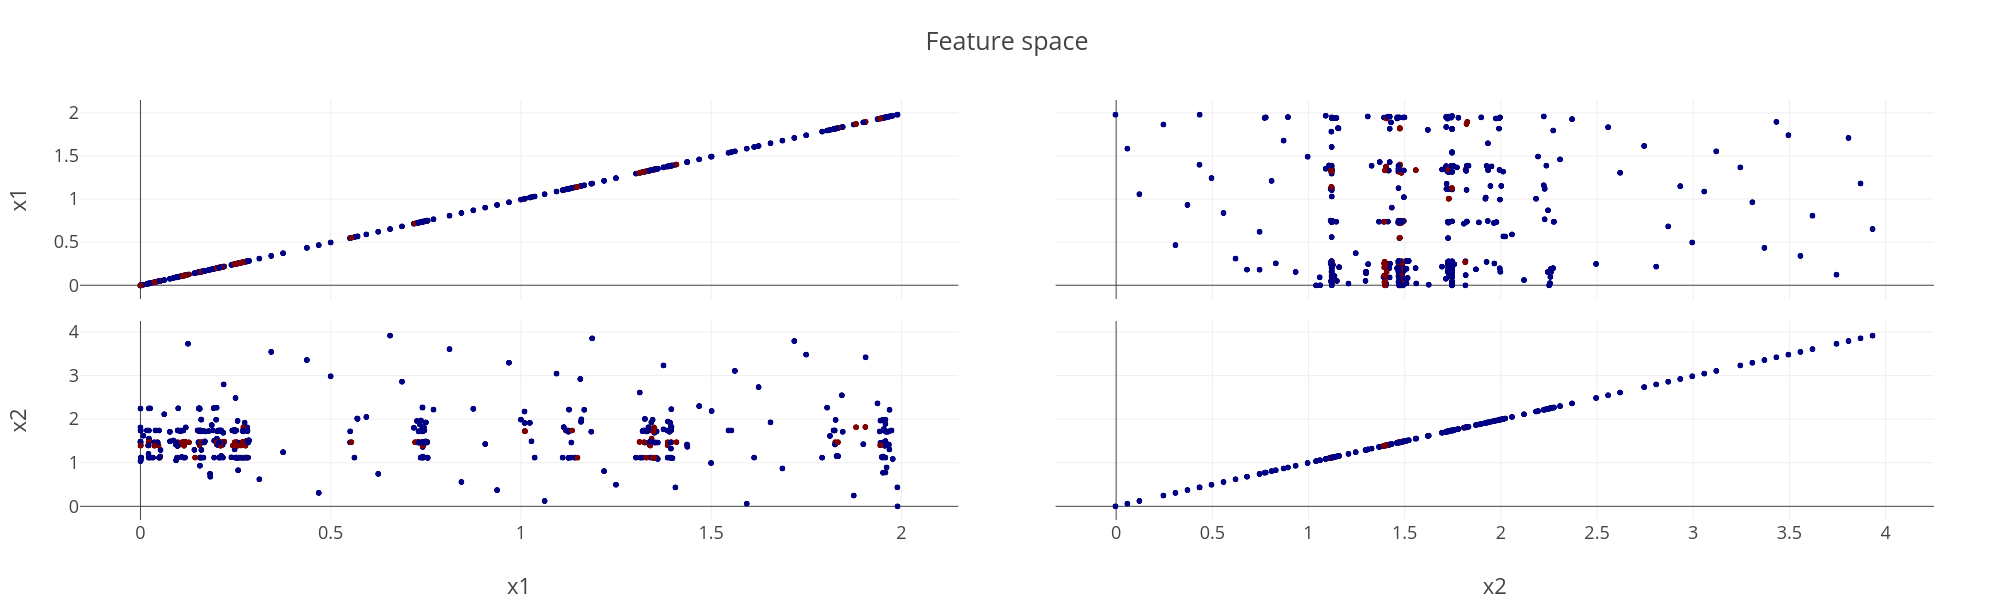

In [42]:
X_ndf = X.copy().reset_index()
X_ndf['ndf'] = 0
X_ndf.loc[ndf[0],['ndf']] = 1
px.scatter_matrix(X_ndf, template="presentation" , dimensions=list(X.columns), color='ndf', color_continuous_scale='Jet', title="Feature space").update_layout(coloraxis_showscale=False)

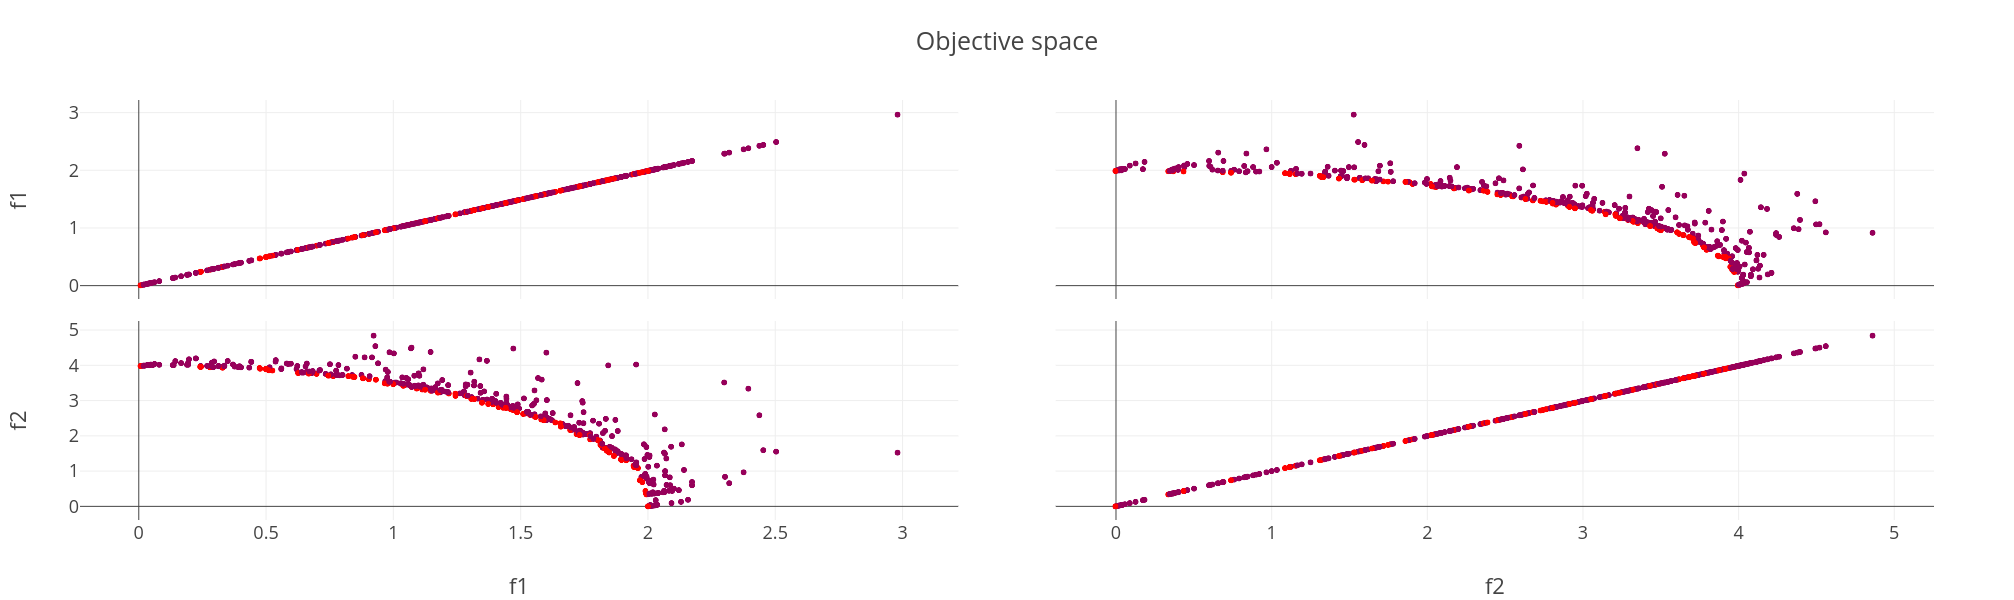

In [43]:
y_ndf = y.copy().reset_index()
y_ndf['ndf'] = 0
y_ndf.loc[ndf[0],['ndf']] = 1
px.scatter_matrix(y_ndf, template="presentation", dimensions=list(y.columns), color='ndf', color_continuous_scale='Rainbow', title="Objective space").update_layout(coloraxis_showscale=False)

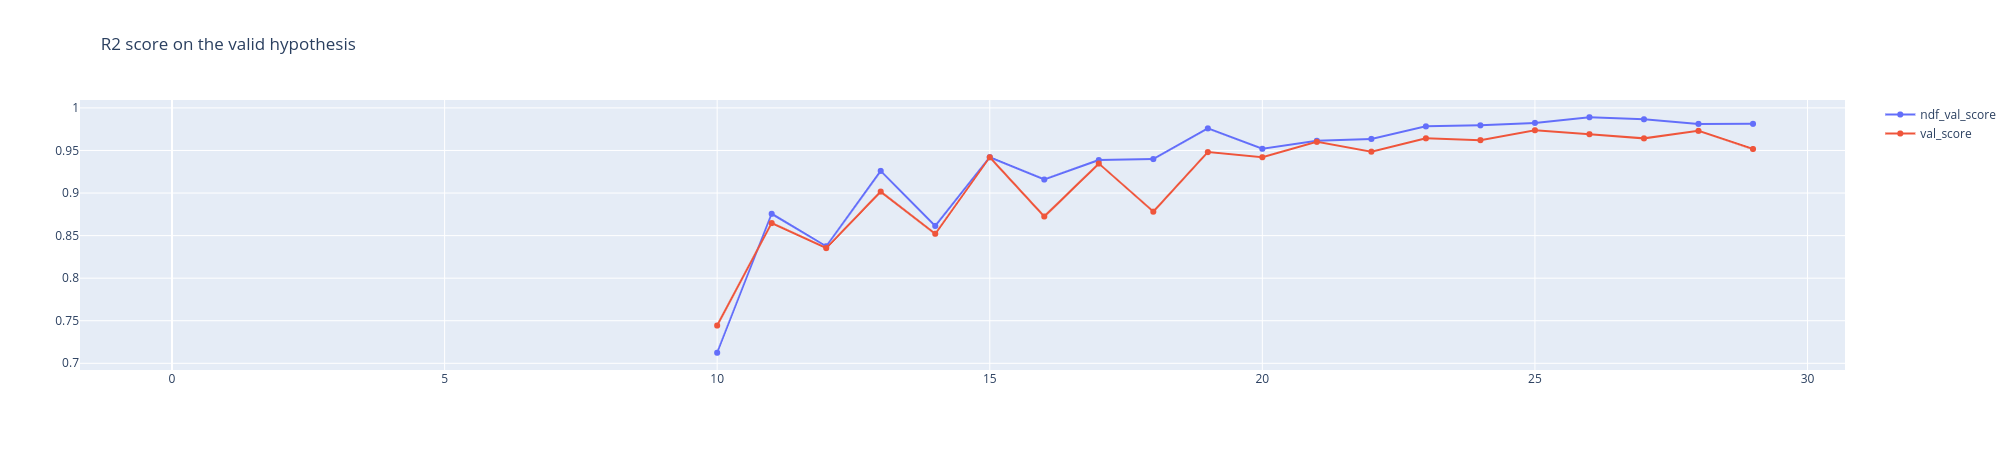

In [108]:
ndf_val_score = [frame.iloc[0]['ndf_val_score'] if isinstance(frame, pd.DataFrame) else frame for frame in iter_solution]
val_score = [frame.iloc[0]['val_score'] if isinstance(frame, pd.DataFrame) else frame for frame in iter_solution]

x = np.arange(len(val_score))
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ndf_val_score,
                    mode='lines+markers',
                    name='ndf_val_score'))
fig.add_trace(go.Scatter(x=x, y=val_score,
                    mode='lines+markers',
                    name='val_score'))
fig.update_layout(title='R2 score on the valid hypothesis')
fig.show()

### *Plotting objectives and search space for the last iteration of tuning
- Red points are Pare front from the hypothesis.
- Blue points are non-dominated solutions from evaluated points. Set of the best solutions available for this iteration.

**if the dimension of problem and objective space is 2*

In [63]:
if OBJ==2 and DIM == 2:
    # Plot last population from TutorModel   
    X, y = gen.return_X_y()
    X = X.reset_index()
    y = y.reset_index()
    
    best_experiments = go.Scatter(x=y.loc[ndf[0],:].f1.values,
                         y=y.loc[ndf[0],:].f2.values,
                         mode='markers',
                         name=u'Dataset. Not-dominated results ',
                         showlegend=False,
                         line=dict(color='blue')
                         )
    
    solver = tutor.solution.solver.values[0]
    fig = plot_mo(solver.problem, solver.population)
    fig.add_trace(best_experiments, row=1, col=1)
    plotly.offline.iplot(fig)